Случайная уставка: 165.64 м (1.624 МПа)


C:\Users\USER\AppData\Local\Temp\ipykernel_33976\2306145866.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('neuro_param_selector.pt', map_location='


Оценка качества:
Классика:   IAE=2.7558, RMSE=0.3591, Overshoot=2.85%, Settling Time=2.73 c
Гибрид:     IAE=2.1670, RMSE=0.3570, Overshoot=0.12%, Settling Time=2.77 c
Нейро-ПИ:   IAE=2.7973, RMSE=0.3283, Overshoot=3.93%, Settling Time=1.84 c

Первые 10 управляющих воздействий классика: [170.409 175.105 181.704 182.256 190.858 182.118 185.382 186.622 193.3
 183.571]
Первые 10 управляющих воздействий гибрид: [174.528 183.364 184.035 184.051 184.051 184.051 184.051 184.051 184.051
 184.051]


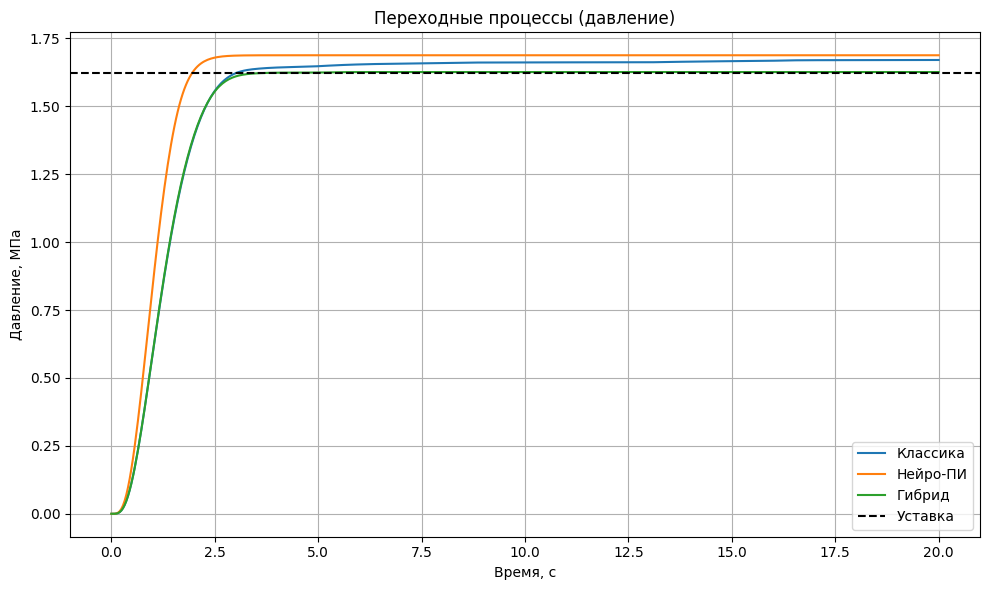

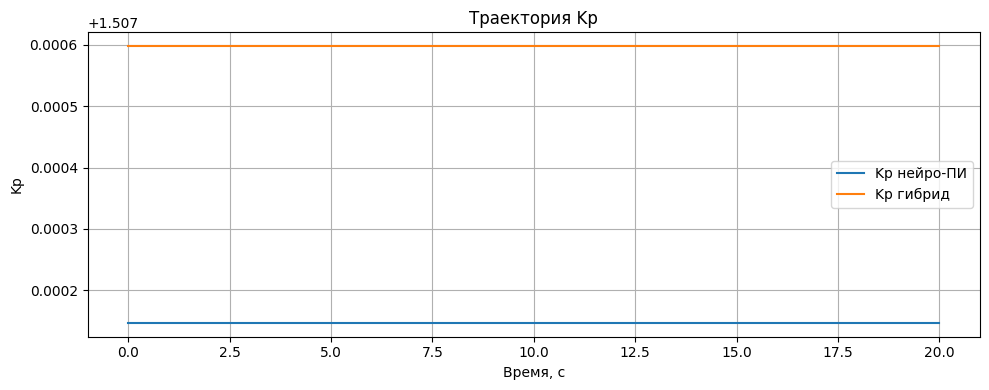

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Настройка шума
SEED = 71
np.random.seed(SEED)
torch.manual_seed(SEED)

NOISE_ENABLED = True
NOISE_LEVEL = 0.03

# Параметры объекта
manual_params = {
    'beta': 19.6783, 'Tm': 0.2995, 'Te': 0.0256, 'Tfc': 0.1038,
    'kfc': 1.6613, 'b': 0.7839, 'h0': 0.7304, 'x0': 1.0180, 'Tp': 0.7938,
}
Kp_os_ratio = 0.2
Ki_os_ratio = 0.15

n_states = 5
T = np.linspace(0, 20, 500)
dt = T[1] - T[0]
X0 = np.zeros(n_states)
params_obj = [manual_params[k] for k in ['beta','Tm','Te','Tfc','kfc','b','h0','x0','Tp']]

# Функция обновления модели
def plant_update(t, x, u, params):
    beta, Tm, Te, Tfc, kfc, b, h0, x0, Tp = params
    x1, x2, x3, x4, x5 = x
    dx1_dt = (1.0 / (beta * Tm)) * (x2 - x1)
    dx2_dt = (beta / Te) * x3 - (beta / Te) * x1 - (1.0 / Te) * x2
    dx3_dt = (kfc / Tfc) * x4 - (1.0 / Tfc) * x3
    k_leak = 5.0
    dx5_dt = ((b / Tp) + ((2.0 * h0 * x0) / Tp)) * x1 - (1.0 / Tp) * x5 - k_leak * x5
    dx4_dt = u[0]
    return [dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt]

# Генерация шума и уставки
setpoint = np.random.uniform(71, 581)
setpoint_mpa = setpoint * 0.00980665
print(f"Случайная уставка: {setpoint:.2f} м ({setpoint_mpa:.3f} МПа)")

noise_array = NOISE_LEVEL * setpoint * np.random.randn(len(T)) if NOISE_ENABLED else np.zeros(len(T))

def get_noise_for_t_idx(idx, noise_array):
    return noise_array[min(idx, len(noise_array)-1)]

# Классический ПИ-регулятор с обратными связями
class PIController:
    def __init__(self, Kp, Ki, dt, Kp_os, Ki_os, config=None, u_min=0, u_max=3000, integral_min=-20, integral_max=20):
        self.Kp = Kp
        self.Ki = Ki
        self.Kp_os = Kp_os
        self.Ki_os = Ki_os
        self.dt = dt
        self.integral = 0.0
        self.u_min = u_min
        self.u_max = u_max
        self.integral_min = integral_min
        self.integral_max = integral_max
        self.x1_prev = None
        self.config = config

    def reset(self):
        self.integral = 0.0
        self.x1_prev = None

    def __call__(self, setpoint, measurement, x1):
        if self.config and self.config.get('noise_enabled', False):
            noise = self.config['noise_level'] * setpoint * np.random.randn()
            measurement += noise
        error = setpoint - measurement
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, self.integral_min, self.integral_max)
        dx1_dt_num = 0.0 if self.x1_prev is None else (x1 - self.x1_prev) / self.dt
        self.x1_prev = x1
        u = (self.Kp * error + self.Ki * self.integral
             - self.Kp_os * dx1_dt_num
             - self.Ki_os * x1)
        return np.clip(u, self.u_min, self.u_max)

# Нейросетевая модель
class ParamNet(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, output_dim),
            nn.Softplus()
        )
    def forward(self, x):
        return self.net(x)

# Загрузка предобученной модели
ckpt = torch.load('neuro_param_selector.pt', map_location='cpu')
X_min, X_max = ckpt['X_min'], ckpt['X_max']
y_mean, y_std = ckpt['y_mean'], ckpt['y_std']
input_dim, output_dim = len(X_min), len(y_mean)
neuro_model = ParamNet(input_dim, output_dim)
neuro_model.load_state_dict(ckpt['model_state_dict'])
neuro_model.eval()

# Нейро-ПИ контроллер
class NeuroPIController:
    def __init__(self, neuro_model, X_min, X_max, y_mean, y_std, dt):
        self.neuro_model = neuro_model
        self.X_min = X_min
        self.X_max = X_max
        self.y_mean = y_mean
        self.y_std = y_std
        self.dt = dt
        self.integral_neuro = 0.0
        self.integral_min = -20
        self.integral_max = 20
        self.x1_prev = None

    def reset(self):
        self.integral_neuro = 0.0
        self.x1_prev = None

    def get_neuro_params(self, setpoint, iae, rmse, overshoot):
        features = np.array([setpoint, 0.0, iae, rmse, overshoot, 1.0], dtype=np.float32)
        features_norm = (features - self.X_min) / (self.X_max - self.X_min + 1e-8)
        features_tensor = torch.tensor(features_norm, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            neuro_params_norm = self.neuro_model(features_tensor).numpy()[0]
        neuro_params = neuro_params_norm * self.y_std + self.y_mean
        Kp_n = np.clip(neuro_params[0], 0.5, 3.0)
        Ki_n = np.clip(neuro_params[1], 0.05, 1.5)
        return Kp_n, Ki_n, features

# Классика с шумом
config = {'noise_enabled': NOISE_ENABLED, 'noise_level': NOISE_LEVEL}
pi_classic = PIController(1.0865, 0.1000, dt, 1.0865*Kp_os_ratio, 0.1000*Ki_os_ratio, config=config)
pi_classic.reset()

u_pi_log = []
def rhs_classic_with_noise(t, x, pi_classic, setpoint, params_obj, T, noise_array):
    measurement = x[4] + get_noise_for_t_idx(np.searchsorted(T, t), noise_array)
    x1 = x[0]
    u = pi_classic(setpoint, measurement, x1)
    if len(u_pi_log) < 10:
        u_pi_log.append(u)
    dx = plant_update(t, x, [u], params_obj)
    return dx

sol_classic = solve_ivp(
    lambda t, x: rhs_classic_with_noise(t, x, pi_classic, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)
pressure_hist_classic = sol_classic.y[4] * 0.00980665

# Нейро-ПИ с шумом
neuro_pi = NeuroPIController(neuro_model, X_min, X_max, y_mean, y_std, dt)
neuro_pi.reset()

iae_buffer, rmse_buffer, overshoot_buffer = [], [], []
Kp_traj_neuro, Ki_traj_neuro = [], []

def rhs_neuro_with_noise(t, x, neuro_pi, setpoint, params_obj, T, noise_array):
    i = np.searchsorted(T, t)
    measurement = x[4] + get_noise_for_t_idx(i, noise_array)
    x1 = x[0]
    
    # Расчет метрик по истории
    y_hist = np.array(iae_buffer + [measurement]) if iae_buffer else np.array([measurement])
    iae = np.sum(np.abs(y_hist - setpoint)) * dt
    rmse = np.sqrt(np.mean((y_hist - setpoint) ** 2))
    overshoot = (np.max(y_hist) - setpoint) / setpoint * 100

    # Обновление параметров нейро-ПИ
    Kp_n, Ki_n, _ = neuro_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_os_n = Kp_n * Kp_os_ratio
    Ki_os_n = Ki_n * Ki_os_ratio
    neuro_pi.Kp = Kp_n
    neuro_pi.Ki = Ki_n
    neuro_pi.Kp_os = Kp_os_n
    neuro_pi.Ki_os = Ki_os_n

    # Интегратор и производная
    error = setpoint - measurement
    neuro_pi.integral_neuro += error * dt
    neuro_pi.integral_neuro = np.clip(neuro_pi.integral_neuro, neuro_pi.integral_min, neuro_pi.integral_max)
    dx1_dt_num = 0.0 if neuro_pi.x1_prev is None else (x1 - neuro_pi.x1_prev) / dt
    neuro_pi.x1_prev = x1

    u_neuro = (neuro_pi.Kp * error + neuro_pi.Ki * neuro_pi.integral_neuro - neuro_pi.Kp_os * dx1_dt_num - neuro_pi.Ki_os * x1)
    u_neuro = np.clip(u_neuro, 0, 3000)

    # Обновление буферов
    iae_buffer.append(measurement)
    rmse_buffer.append(measurement)
    overshoot_buffer.append(measurement)
    Kp_traj_neuro.append(Kp_n)
    Ki_traj_neuro.append(Ki_n)

    dx = plant_update(t, x, [u_neuro], params_obj)
    return dx

sol_neuro = solve_ivp(
    lambda t, x: rhs_neuro_with_noise(t, x, neuro_pi, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)
pressure_hist_neuro = sol_neuro.y[4] * 0.00980665

# Гибридный ПИ-регулятор
def get_dynamic_weight(t, T_total, w_start=0.0, w_end=0.4):
    return w_start + (w_end - w_start) * min(t / T_total, 1.0)

def get_weight_by_noise(noise_level):
    if noise_level == 0.0:
        return 0.0
    elif noise_level > 0.06:
        return 1.0
    elif noise_level > 0.02:
        return 0.5
    else:
        return 0.0

hybrid_pi = NeuroPIController(neuro_model, X_min, X_max, y_mean, y_std, dt)
hybrid_pi.reset()
for i, t in enumerate(T):
    current_noise_level = abs(get_noise_for_t_idx(i, noise_array)) 
    weight_neuro = get_weight_by_noise(current_noise_level)
    hybrid_pi.weight = weight_neuro

pi_classic_hybrid = PIController(1.0865, 0.1000, dt, 1.0865*Kp_os_ratio, 0.1000*Ki_os_ratio, config=config)
pi_classic_hybrid.reset()
pi_neuro_hybrid = PIController(0.1, 0.05, dt, 0.0, 0.0)
pi_neuro_hybrid.reset()

u_h_log = []
def rhs_hybrid_with_noise_param_mix(t, x, hybrid_pi, setpoint, params_obj, T, noise_array):
    i = np.searchsorted(T, t)
    measurement = x[4] + get_noise_for_t_idx(i, noise_array)
    x1 = x[0]

    # Параметры классики
    Kp_classic = 1.0865
    Ki_classic = 0.1000
    Kp_os_classic = Kp_classic * Kp_os_ratio
    Ki_os_classic = Ki_classic * Ki_os_ratio

    # Параметры нейро-ПИ
    iae = 0.0
    rmse = 0.0
    overshoot = 0.0
    Kp_neuro, Ki_neuro, _ = hybrid_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_os_neuro = Kp_neuro * Kp_os_ratio
    Ki_os_neuro = Ki_neuro * Ki_os_ratio

   # Динамический вес
    T_total = T[-1]
    w = get_dynamic_weight(t, T_total, w_start=0.0, w_end=weight_neuro)

    # Смешанные параметры
    Kp_h = (1 - w) * Kp_classic + w * Kp_neuro
    Ki_h = (1 - w) * Ki_classic + w * Ki_neuro
    Kp_os_h = (1 - w) * Kp_os_classic + w * Kp_os_neuro
    Ki_os_h = (1 - w) * Ki_os_classic + w * Ki_os_neuro

    # Инициализация гибридного PI контроллера при первом вызове
    if not hasattr(rhs_hybrid_with_noise_param_mix, "pi_hybrid"):
        rhs_hybrid_with_noise_param_mix.pi_hybrid = PIController(
            Kp_h, Ki_h, dt, Kp_os_h, Ki_os_h)
        rhs_hybrid_with_noise_param_mix.pi_hybrid.reset()
    pi_hybrid = rhs_hybrid_with_noise_param_mix.pi_hybrid

    # Обновление параметров контроллера
    pi_hybrid.Kp = Kp_h
    pi_hybrid.Ki = Ki_h
    pi_hybrid.Kp_os = Kp_os_h
    pi_hybrid.Ki_os = Ki_os_h

    u_h = pi_hybrid(setpoint, measurement, x1)
    u_h = np.clip(u_h, 0, 3000)

    if len(u_h_log) < 10:
        u_h_log.append(u_h)

    dx = plant_update(t, x, [u_h], params_obj)
    return dx

# Сброс перед запуском
if hasattr(rhs_hybrid_with_noise_param_mix, "pi_hybrid"):
    rhs_hybrid_with_noise_param_mix.pi_hybrid.reset()

sol_hybrid = solve_ivp(
    lambda t, x: rhs_hybrid_with_noise_param_mix(t, x, hybrid_pi, setpoint, params_obj, T, noise_array),
    [T[0], T[-1]], X0.copy(), t_eval=T, method='RK45', rtol=1e-6, atol=1e-8
)

# Траектории параметров гибрида
Kp_traj_hybrid = []
Ki_traj_hybrid = []
for t in T:
    iae = 0.0
    rmse = 0.0
    overshoot = 0.0
    Kp_n, Ki_n, _ = hybrid_pi.get_neuro_params(setpoint, iae, rmse, overshoot)
    Kp_traj_hybrid.append(Kp_n)
    Ki_traj_hybrid.append(Ki_n)

pressure_hist_hybrid = sol_hybrid.y[4] * 0.00980665

# Функция для оценки качества
def calc_metrics(pressure_hist, setpoint, T):
    iae = np.sum(np.abs(pressure_hist - setpoint)) * dt
    rmse = np.sqrt(np.mean((pressure_hist - setpoint) ** 2))
    overshoot = (np.max(pressure_hist) - setpoint) / setpoint * 100
    tolerance = 0.02 * setpoint
    settled_indices = np.where(np.abs(pressure_hist - setpoint) <= tolerance)[0]
    settling_time = T[settled_indices[0]] if len(settled_indices) > 0 else T[-1]
    return iae, rmse, overshoot, settling_time

pressure_setpoint = setpoint * 0.00980665
metrics_classic = calc_metrics(pressure_hist_classic, pressure_setpoint, T)
metrics_hybrid = calc_metrics(pressure_hist_hybrid, pressure_setpoint, T)
metrics_neuro = calc_metrics(pressure_hist_neuro, pressure_setpoint, T)

# Вывод результатов
print("\nОценка качества:")
print(f"Классика:   IAE={metrics_classic[0]:.4f}, RMSE={metrics_classic[1]:.4f}, Overshoot={metrics_classic[2]:.2f}%, Settling Time={metrics_classic[3]:.2f} c")
print(f"Гибрид:     IAE={metrics_hybrid[0]:.4f}, RMSE={metrics_hybrid[1]:.4f}, Overshoot={metrics_hybrid[2]:.2f}%, Settling Time={metrics_hybrid[3]:.2f} c")
print(f"Нейро-ПИ:   IAE={metrics_neuro[0]:.4f}, RMSE={metrics_neuro[1]:.4f}, Overshoot={metrics_neuro[2]:.2f}%, Settling Time={metrics_neuro[3]:.2f} c")

print("\nПервые 10 управляющих воздействий классика:", np.round(u_pi_log, 3))
print("Первые 10 управляющих воздействий гибрид:", np.round(u_h_log, 3))

# Графики
plt.figure(figsize=(10, 6))
plt.plot(T, pressure_hist_classic, label='Классика')
plt.plot(T, pressure_hist_neuro, label='Нейро-ПИ')
plt.plot(T, pressure_hist_hybrid, label='Гибрид')
plt.axhline(pressure_setpoint, color='k', linestyle='--', label='Уставка')
plt.xlabel('Время, с')
plt.ylabel('Давление, МПа')
plt.title('Переходные процессы (давление)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(T, Kp_traj_neuro[:len(T)], label='Kp нейро-ПИ')
plt.plot(T, Kp_traj_hybrid[:len(T)], label='Kp гибрид')
plt.xlabel('Время, с')
plt.ylabel('Kp')
plt.title('Траектория Kp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(T, Ki_traj_neuro[:len(T)], label='Ki нейро-ПИ')
plt.plot(T, Ki_traj_hybrid[:len(T)], label='Ki гибрид')
plt.xlabel('Время, с')
plt.ylabel('Ki')
plt.title('Траектория Ki')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
weights = [get_dynamic_weight(t, T[-1], w_start=0.0, w_end=weight_neuro) for t in T]
plt.plot(T, weights)
plt.xlabel('Время, c')
plt.ylabel('Вес нейро-ПИ')
plt.title('Динамика веса нейро-ПИ в гибриде')
plt.grid(True)
plt.tight_layout()
plt.show()